# 2025-03-19 Linear solvers

## Last time

* Wave equation and Hamiltonians
* Symplectic integrators

## Today

* Sparse direct solvers
  * matrix orderings
  * impact on formulation
  * cost scaling
  

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end
    
function plot_stability(Rz, title; xlims=(-2, 2), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)

function ode_rk_explicit(f, u0; tfinal=1., h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

In [2]:
function laplacian_matrix(n)
    h = 2 / n
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    wrap(i) = (i + n - 1) % n + 1
    idx(i, j) = (wrap(i)-1)*n + wrap(j)
    stencil_diffuse = [-1, -1, 4, -1, -1] / h^2
    for i in 1:n
        for j in 1:n
            append!(rows, repeat([idx(i,j)], 5))
            append!(cols, [idx(i-1,j), idx(i,j-1), idx(i,j), idx(i+1,j), idx(i,j+1)])
            append!(vals, stencil_diffuse)
        end
    end
    sparse(rows, cols, vals)
end

laplacian_matrix (generic function with 1 method)

In [3]:
function wave_matrix(n; a=1)
    Z = spzeros(n^2, n^2)
    L = laplacian_matrix(n)
    [Z I; -a^2*L Z]
end

wave_matrix (generic function with 1 method)

In [4]:
function energy(sol, n)
    L = laplacian_matrix(n)
    rho = sol[1:end÷2]
    rhodot = sol[end÷2+1:end]
    kinetic = .5 * norm(rhodot)^2
    potential = .5 * rho' * L * rho
    kinetic + potential
end

energy (generic function with 1 method)

In [5]:
function wave_verlet(n, u0; tfinal=1., h=0.1)
    L = laplacian_matrix(n)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    irho = 1:n^2
    irhodot = n^2+1:2*n^2
    accel = -L * u[irho]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        u[irho] += h * u[irhodot] + h^2/2 * accel
        accel_next = -L * u[irho]
        u[irhodot] += h/2 * (accel + accel_next)
        accel = accel_next
        t = tnext
        push!(thist, t)
        push!(uhist, copy(u))
    end
    thist, hcat(uhist...)
end

wave_verlet (generic function with 1 method)

# Start with advection-diffusion operator in 2D

* Eliminate Dirichlet boundary conditions around all sides

In [6]:
function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n # What does this do?
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

norm(A - A') = 0.0


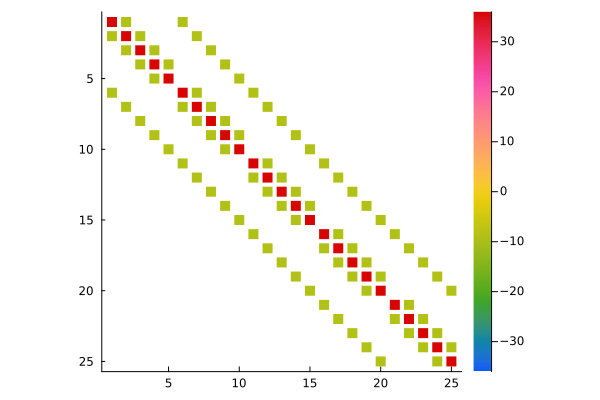

In [7]:
A = advdiff_matrix(5, wind=[0, 0])
@show norm(A - A') # Is this matrix symmetric?
my_spy(A)

**Question**: What structure does this matrix have?

* Sparse
* Symmetric (automatically Hermitian if real)
* Banded. _Bandwidth_ is the smallest non-negative integer $k$ such that $A_{ij} = 0 \;\;  \forall \; |i - j| > k$. What is it?

# Direct methods

Gaussian elimination and Cholesky

## $LU = A$ (Gaussian elimination / LU decomposition)
Given a $2\times 2$ block matrix, the algorithm proceeds as
\begin{split}
  \begin{bmatrix} A & B \\ C & D \end{bmatrix} =
  \begin{bmatrix} L_A & \\ C U_A^{-1} & 1 \end{bmatrix}
  \begin{bmatrix} U_A & L_A^{-1} B \\ & S \end{bmatrix}
\end{split}
where $L_A U_A = A$ and
$$S = D - C \underbrace{U_A^{-1} L_A^{-1}}_{A^{-1}} B  \quad \text{is the Schur complement of the block }A.$$

## $L L^T = A$ [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition) decomposition
\begin{split}
  \begin{bmatrix} A & B^T \\ B & D \end{bmatrix} =
  \begin{bmatrix} L_A & \\ B L_A^{-T} & 1 \end{bmatrix}
  \begin{bmatrix} L_A^T & L_A^{-1} B^T \\ & S \end{bmatrix}
\end{split}
where $L_A L_A^T = A$ and
$$ S = D - B \underbrace{L_A^{-T} L_A^{-1}}_{A^{-1}} B^T .$$

In [ ]:
A = advdiff_matrix(5)
N = size(A, 1)
ch = cholesky(A, perm=1:N)
my_spy(A)
my_spy(sparse(ch.L))

If $A$ was banded (e.g. tridiagonal), then Cholesky factor $L$ is also banded (with the same bandwidth!)

# Cost of a banded solve

* Consider an $N\times N$ matrix with bandwidth $b$, $1 \le b \le N$ (Thomas' algorithm)

    * Work one row at a time
    * Each row/column of panel has $b$ nonzeros
    * Schur update affects $b\times b$ sub-matrix
    * Total compute cost $N b^2$
    * Storage cost $N b$

**Question**:
* What bandwidth $b$ is needed for an $N = n\times n \times n$ cube in 3 dimensions?
* What is the memory cost?
* What is the compute cost?

In [ ]:
my_spy(sparse(ch.L))

# Different orderings

In [ ]:
n = 20
A = advdiff_matrix(n)
heatmap(reshape(1:n^2, n, n))
#reshape(1:n^2, n, n)

## [Metis](https://github.com/JuliaSparse/Metis.jl)

In [ ]:
import Metis
perm, iperm = Metis.permutation(A)
heatmap(reshape(iperm, n, n))

In [ ]:
cholesky(A, perm=1:n^2)

In [ ]:
cholesky(A, perm=Vector{Int64}(perm))

# Cholesky factors in nested dissection

In [ ]:
n = 10
A = advdiff_matrix(n)
perm, iperm = Metis.permutation(A)
my_spy(A[perm, perm])

In [ ]:
ch = cholesky(A, perm=Vector{Int64}(perm))
my_spy(sparse(ch.L))

* The dense blocks in factor $L$ are "supernodes"
* They correspond to "vertex separators" in the ordering

# Cost in nested dissection

* Cost is dominated by dense factorization of the largest supernode
* Its size comes from the vertex separator size

## 2D square

* $N = n^2$ dofs
* Vertex separator of size $n$
* Compute cost $v^3 = N^{3/2}$
* Storage cost $N \log N$

## 3D Cube

* $N = n^3$ dofs
* Vertex separator of size $v = n^2$
* Compute cost $v^3 = n^6 = N^2$
* Storage cost $v^2 = n^4 = N^{4/3}$

## Questions

1. How much does the cost change if we switch from Dirichlet to periodic boundary conditions in 2D?
2. How much does the cost change if we move from 5-point stencil ($O(h^2)$ accuracy) to 9-point "star" stencil ($O(h^4)$ accuracy)?
3. Would you rather solve a 3D problem on a $10\times 10\times 10000$ grid or $100\times 100 \times 100$?

# Test our intuition

In [ ]:
n = 50
A_dirichlet = advdiff_matrix(n)
perm, iperm = Metis.permutation(A_dirichlet)
cholesky(A_dirichlet, perm=Vector{Int64}(perm))
#cholesky(A_dirichlet)

In [ ]:
A_periodic = laplacian_matrix(n) + 1e-10*I # To make it num psd
perm, iperm = Metis.permutation(A_periodic)
ch = cholesky(A_periodic, perm=Vector{Int64}(perm))
#cholesky(A_periodic)
my_spy(sparse(ch.L))

# How expensive how fast?

Suppose we have a second order accurate method in 3D.

In [ ]:
n = 2. .^ (2:13)
N = n.^3
error = (50 ./ n) .^ 2
seconds = 1e-10 * N.^2
hours = seconds / 3600
cloud_dollars = 3 * hours
kW_hours = 0.2 * hours
barrel_of_oil = kW_hours / 1700
kg_CO2 = kW_hours * 0.709
;

In [ ]:
cost = hours
plot(cost, error, xlabel="cost", ylabel="error", xscale=:log10, yscale=:log10)

* [Barrel of oil equivalent](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent)
* [Electricity emission factor](https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references)

# Outlook on sparse direct solvers

* Sparse direct works well for 2D and almost-2D problems to medium large sizes
  * High order FD methods make sparse direct cry
  * Almost-2D includes a lot of industrial solid mechanics applications
    * The body of a car, the frame of an airplane
* Sparse direct is rarely usable in "fully 3D" problems
  * "thick" structures
    * soil mechanics, hydrology, building foundations, bones, tires
  * fluid mechanics
    * aerodynamics, heating/cooling systems, atmosphere/ocean
* Setup cost (factorization) is much more expensive than solve
  * Amortize cost in time-dependent problems
    * Rosenbrock methods: factorization reused across stages
    * "lag" Jacobian in Newton (results in "modified Newton")
    * "lag" preconditioner with matrix-free iterative methods (Sundials, PETSc)
  * Factorization pays off if you have many right hand sides

# Iterative solvers

* Less reliable, more leaky abstraction
* More sensitive to problem formulation
* Slower for small problems
* Several different strategies, each with tuning knobs
* Accuracy tolerances needed

## $O(N)$ solvers available for many important problems
* High-order discretization *can* be okay